## Core.py

In [1]:
import os
import pandas as pd
import numpy as np
from lmfit import Minimizer, fit_report
from datetime import datetime

class PrimarySolver:
    # Class Constants
    DATA_PATH = "./data/NLData.csv" # Default path to data
    DOCS_PATH = "./docs/" # Default path to save docs
    IMG_PATH = "./img/" # Default path to save images

    REPORT_NAME = "report.txt"
    
    PRINT_ITERS = 100 # Print solve status after this many iterations
    NUM_ITERS = 10 # Iterate solve w/ new randomized weights this many times
    NUM_PARAMS = 7 # Number of parameters in objective function

    def read(self, path=DATA_PATH):
        """
        Import NL data from given CSV file.

        Keyword Arguments:
        path -- the path to the desired data file, defaults to DATA_PATH static var
        """
        # Read CSV
        df = pd.read_csv(path, index_col=0)

        # Format time as datetime object
        df["t"] = df["t"].apply(str_to_datetime)

        # Extract training & validation datasets
        self.char_1_data = df[df["test_name"] == "char_1"]
        self.char_2_data = df[df["test_name"] == "char_2"]
        self.val_data = df[df["test_name"] == "val"]

    def solve(self, char_set="all", method="least_sq"):
        """
        Finds f(x,y,z,p) such that the error ||v-f(x,y,z,p)|| is minimized.

        Utilizes lmfit optimization library (based on SciPy)

        Keyword Arguments:
        char_set   -- the dataset to use, by default utilizes all available training data
        method     -- the least squares minimization method to use, by default Levenberg-Marquardt
                                This was experimentally determined to produce best results

        Returns:
        bestResult -- the best model parameters found through NL least squares minimization
        """

        # Prepare data
        if char_set == "char_1":
            x = self.char_1_data["x"]
            y = self.char_1_data["y"]
            z = self.char_1_data["z"]
            v = self.char_1_data["v"]
        elif char_set == "char_2":
            x = self.char_2_data["x"]
            y = self.char_2_data["y"]
            z = self.char_2_data["z"]
            v = self.char_2_data["v"]
        elif char_set == "all":
            x = pd.concat([self.char_1_data["x"], self.char_2_data["x"]])
            y = pd.concat([self.char_1_data["y"], self.char_2_data["y"]])
            z = pd.concat([self.char_1_data["z"], self.char_2_data["z"]])
            v = pd.concat([self.char_1_data["v"], self.char_2_data["v"]])
        else:
            print("ERROR: Invalid char_set")
            return

        # Perform minimization
        minner = Minimizer(residual_calc, randomize_parameters(), fcn_args=(x, y, z, v))
        self.bestResult = minner.minimize(method=method)
        if not self.bestResult.success:
            print("Error: minimization failed!")
            return
        self.bestSum = np.sum(np.square(residual_calc(self.bestResult.params, x, y, z, v)))

        # Run for a set number of times and return best params found to account 
        # for randomly landing in local min from starting values
        for i in range(self.NUM_ITERS):
            # Print iteration count
            if (i + 1) % self.PRINT_ITERS == 0:
                print("Iteration " + str(i + 1) + " of " +  str(self.NUM_ITERS))

            # Generate new parameters and re-minimize
            minner.params = randomize_parameters()
            result = minner.minimize(method=method)
            if not self.bestResult.success:
                print("Error: minimization failed!")
                return
            sum = np.sum(np.square(residual_calc(result.params, x, y, z, v)))

            # Check if new min is better
            if sum < self.bestSum:
                self.bestSum = sum
                self.bestResult = result
        return self.bestResult

    def validate(self, p=None):
        """
        Calculates resuiduals & returns RSS on validation data

        Keyword Arguments:
        p   -- custom parameters to use, by default will use bestResult.params

        Returns:
        SSR -- sum of squares of residuals from validation data
        """
        if not p:
            if not self.bestResult:
                print("Error: run solve function first!")
                return
            p = self.bestResult.params
        self.valResiduals = residual_calc(p, self.val_data["x"], self.val_data["y"], self.val_data["z"], self.val_data["v"])
        self.SSR = np.sum(np.square(self.valResiduals))
        return self.SSR

    def report(self, char_set="all", printout=False):
        """
        Generates report analyzing success of model optimization

        Keyword Arguments:
        char_set -- the dataset used, by default all available training data
        printout -- Whether to print out the report or not, by default set to False
        """
        # Ensures that both solve() and validate() have been run to correctly generate report
        if not self.bestResult:
            print("Error: run solve function first!")
            return
        if self.valResiduals is None:
            print("Error: run validate function first!")
            return

        # Retrieve correct timestamps
        if char_set == "char_1":
            t = [self.char_1_data["t"]]
        elif char_set == "char_2":
            t = [self.char_2_data["t"]]
        elif char_set == "all":
            t = [self.char_1_data["t"], self.char_2_data["t"]]
        else:
            print("ERROR: Invalid char_set")
            return

        # Generate report text
        if not os.path.exists(self.DOCS_PATH):
            os.mkdir(self.DOCS_PATH)
        file_name = self.DOCS_PATH + char_set + "_" + self.REPORT_NAME
        if not printout:
            with open(file_name, "w") as f:
                print("\nTraining results:", file=f)
                print("------------------------------------------------------", file=f)
                print(fit_report(self.bestResult), file=f)
                print("\nValidation results:", file=f)
                print("------------------------------------------------------", file=f)
                print("# data points      = " + str(len(self.val_data["v"])), file=f)
                print("chi-square         = " + str(self.SSR), file=f)
                print("reduced chi-square = " + str(self.SSR / (len(self.val_data["v"]) - len(self.bestResult.params))), file=f)
            print("Generated report at " + file_name)
        else:
            print("\nTraining results:")
            print("------------------------------------------------------")
            print(fit_report(self.bestResult))
            print("\nValidation results:")
            print("------------------------------------------------------")
            print("# data points      = " + str(len(self.val_data["v"])))
            print("chi-square         = " + str(self.SSR))
            print("reduced chi-square = " + str(self.SSR / (len(self.val_data["v"]) - len(self.bestResult.params))))

        # Generate plots
        if not os.path.exists(self.IMG_PATH):
            os.mkdir(self.IMG_PATH)
        train_img_path = self.IMG_PATH + char_set + "_train_"
        val_img_path = self.IMG_PATH + char_set + "_val_"
        if printout:
            print("\nTraining plots:")
            print("------------------------------------------------------")
        plot_residual_over_time(t, self.bestResult.residual, save_path=train_img_path)
        plot_residual_histogram(self.bestResult.residual, save_path=train_img_path)
        if printout:
            print("\nValidation plots:")
            print("------------------------------------------------------")
        plot_residual_over_time([self.val_data["t"]], self.valResiduals, save_path=val_img_path)
        plot_residual_histogram(self.valResiduals, save_path=val_img_path)
        if not printout:
            print("Generated plots at " + self.IMG_PATH)


## Helpers.py

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from lmfit import create_params, Parameters

def randomize_parameters():
    """
    Create LMFIT model parameters initialized randomly between [0,1)

    Returns:
    p -- Model parameters loaded with random values
    """
    p = Parameters()
    # Each value can be constrained if needed
    p.add("rAmp", value=np.random.random())
    p.add("thetaAmp", value=np.random.random())
    p.add("thetaFreq", value=np.random.random())
    p.add("thetaPhase", value=np.random.random())
    p.add("phiAmp", value=np.random.random())
    p.add("phiFreq", value=np.random.random())
    p.add("phiPhase", value=np.random.random())
    return p

def str_to_datetime(s):
    """
    Convert timestamp string to datetime object

    Keyword arguments:
    s -- timestamp string to convert

    Returns:
    t -- datetime representation of timestamp
    """
    return datetime.strptime(s, "%Y-%m-%d %H:%M:%S.%f")

def plot_cart(x,y,z):
    """
    Plot 3-D cartesian coordinates with MatPlotLib

    Keyword arguments:
    x, y, z -- Cartesian coordinates
    """
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.scatter(x,y,z)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

def plot_spher(r,theta,phi):
    """
    Plot spherical coordinates with MatPlotLib

    Keyword arguments:
    r, theta, phi -- Spherical coordinates
    """
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    x,y,z = spher_to_cart(r,theta,phi)
    ax.scatter(x,y,z)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

def plot_residual_histogram(r, save_path=None, num_bins=30):
    """
    Plots residuals in a histogram

    Keyword arguments:
    r         -- Residuals to plot
    save_path -- Path to save image to, if none is given then will show plot
    num_bins  -- Number of bins in the histogram, by default 30
    """
    fig = plt.figure()
    fig.suptitle('Residuals Histogram', fontsize=20)
    hist, bins = np.histogram(r, bins=num_bins)
    plt.bar((bins[:-1] + bins[1:]) / 2, hist, align='center', width=0.8 * (bins[1] - bins[0]))
    if save_path:
        plt.savefig(save_path + "residual_histogram.png")
    plt.show()

def plot_residual_over_time(t, r, save_path=None):
    """
    Plots residuals as a function of time

    Keyword arguments:
    t         -- Array of datetime object series representing timestamp of each measurement
    r         -- Residual corresponding with the timestamp
    save_path -- Path to save image to, if none is given then will show plot
    """
    fig = plt.figure()
    fig.suptitle('Residuals over time')
    ax = fig.add_subplot()

    if len(t) == 1:
        ax.scatter(t[0], r)
    else:
        # If there are multiple datasets used, plot in separate colors
        ax.scatter(t[0], r[0:len(t[0])], label="char_1")
        ax.scatter(t[1], r[len(t[0]):], label="char_2")
        plt.legend()
    ax.set_xlabel("Time")
    ax.set_ylabel("Residual")
    ax.grid(True)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    if save_path:
        plt.savefig(save_path + "residuals_over_time.png")
    plt.show()

## Functions.py

In [3]:
import numpy as np

def cart_to_spher(x, y, z):
    """
    Calculates spherical coordinates based off of 3-D cartesian coordinates

    Based off Wolfram reference: https://mathworld.wolfram.com/SphericalCoordinates.html

    Keyword arguments:
    x, y, z       -- Cartesian coordinates

    Returns:
    r, theta, phi -- Spherical coordinate equivalent (in rads)
    """
    r = np.sqrt(np.square(x) + np.square(y) + np.square(z))
    theta = np.arctan2(y,x)
    phi = np.arccos(z/r)
    return r, theta, phi

def spher_to_cart(r, theta, phi):
    """
    Calculates 3-D cartesian coordinates based off of spherical coordinates

    Based off Wolfram reference: https://mathworld.wolfram.com/SphericalCoordinates.html

    Keyword arguments:
    r, theta, phi -- Spherical coordinates (in rads)

    Returns:
    x, y, z       -- Cartesian coordinate equivalent
    """
    x = r * np.cos(theta) * np.sin(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(phi)
    return x, y, z

def f(r, theta, phi, p):
    """
    Specific function for NL LS optimization

    f(r,theta,psi,p) = p[0]*r^2 + p[1]*sin(p[2]*theta+p[3])^2 + p[4]*sin(p[5]*psi+p[6])^2

    Keyword Arguments:
    r, theta, phi       -- Spherical coordinates (in rads)
    p                   -- 7 weight dictionary
    
    Returns:
    f(r, theta, phi, p) -- calculation defined in Project Objective
    """
    return p["rAmp"] * np.square(r) +\
        p["thetaAmp"] * np.square(np.sin(p["thetaFreq"] * theta + p["thetaPhase"])) +\
        p["phiAmp"] * np.square(np.sin(p["phiFreq"] * phi + p["phiPhase"]))

def residual_calc(p, x, y, z, v):
    """
    Calculates residuals using measured & predicted outputs

    Keyword Arguments:
    p       -- Dictionary of weight parameters
    x, y, z -- Cartesian coordinates
    v       -- Output vector corresponding with coordinates

    Returns:
    Vector of residuals
    """
    return v - f(*cart_to_spher(x, y, z), p)

# Experiments

In [4]:
solv = PrimarySolver()
solv.read()

Fit with both training datasets

Training results:
------------------------------------------------------
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 168
    # data points      = 10000
    # variables        = 7
    chi-square         = 10696.8669
    reduced chi-square = 1.07043600
    Akaike info crit   = 687.657937
    Bayesian info crit = 738.130319
[[Variables]]
    rAmp:        2.81877762 +/- 0.00561117 (0.20%) (init = 0.8569313)
    thetaAmp:    1.08198821 +/- 0.02626894 (2.43%) (init = 0.4962007)
    thetaFreq:   0.55577132 +/- 0.00650564 (1.17%) (init = 0.8858238)
    thetaPhase:  0.71071094 +/- 0.01305707 (1.84%) (init = 0.238141)
    phiAmp:      2.92102101 +/- 0.02587398 (0.89%) (init = 0.3654435)
    phiFreq:     1.47745249 +/- 0.00572031 (0.39%) (init = 0.928293)
    phiPhase:    0.06018832 +/- 0.01026250 (17.05%) (init = 0.5369917)
[[Correlations]] (unreported correlations are < 0.100)
    C(phiFreq, phiPhase)   = -0.8601
    C(rAmp

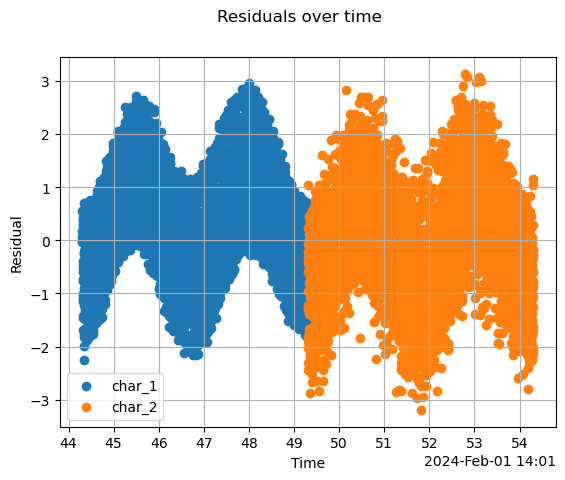

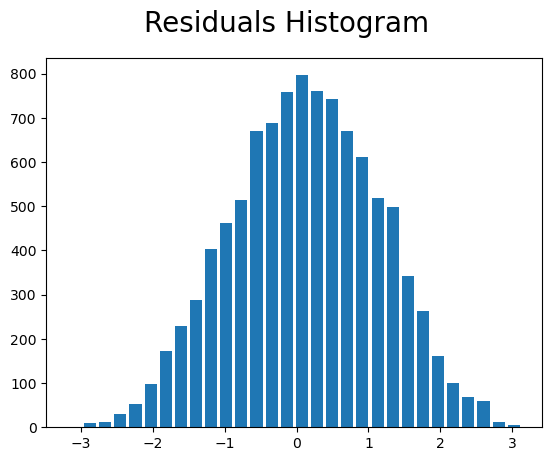


Validation plots:
------------------------------------------------------


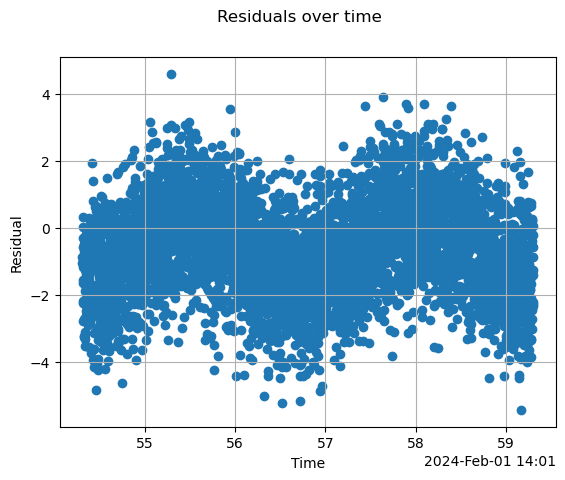

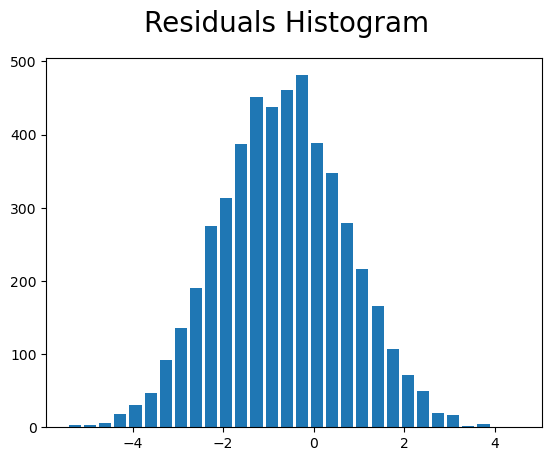

In [5]:
print("Fit with both training datasets")
result = solv.solve()
SSR = solv.validate()
solv.report(printout=True)

Fit with Char 1 dataset only

Training results:
------------------------------------------------------
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 81
    # data points      = 5000
    # variables        = 7
    chi-square         = 4259.75414
    reduced chi-square = 0.85314523
    Akaike info crit   = -787.132335
    Bayesian info crit = -741.511983
[[Variables]]
    rAmp:        0.19240973 +/- 0.32277756 (167.76%) (init = 0.3194293)
    thetaAmp:    3.94174912 +/- 0.33024651 (8.38%) (init = 0.9318914)
    thetaFreq:   0.05255399 +/- 0.01155365 (21.98%) (init = 0.1523476)
    thetaPhase:  1.37115191 +/- 0.04526947 (3.30%) (init = 0.6984662)
    phiAmp:      2.40913143 +/- 0.03732454 (1.55%) (init = 0.9517772)
    phiFreq:     1.50167608 +/- 0.00901861 (0.60%) (init = 0.1592908)
    phiPhase:   -0.00339130 +/- 0.01631728 (481.15%) (init = 0.9933043)
[[Correlations]] (unreported correlations are < 0.100)
    C(rAmp, thetaAmp)        = -0.9822
    C

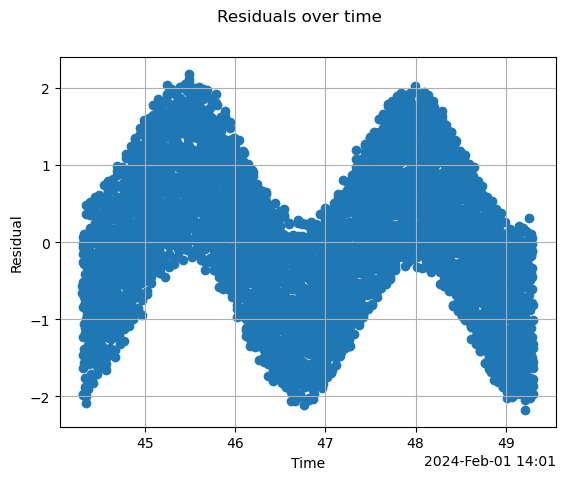

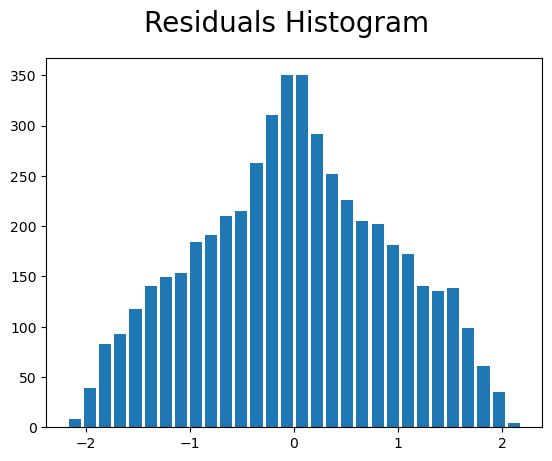


Validation plots:
------------------------------------------------------


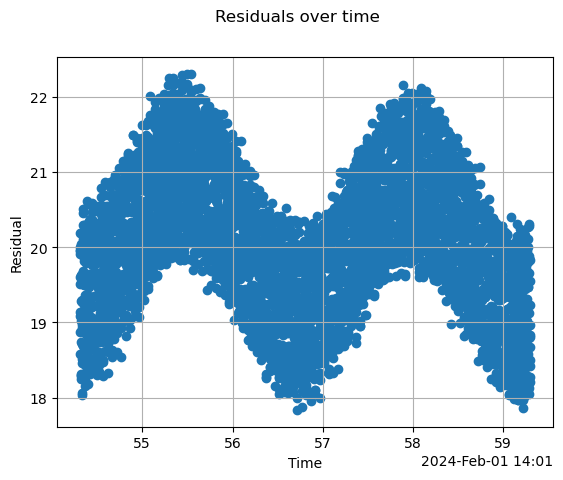

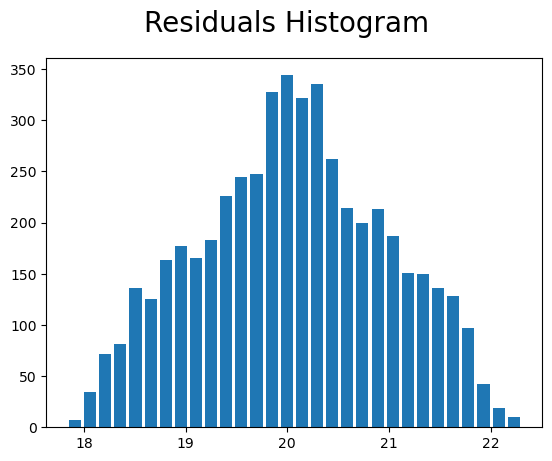

In [6]:
print("Fit with Char 1 dataset only")
result = solv.solve(char_set="char_1")
SSR = solv.validate()
solv.report(char_set="char_1", printout=True)

Fit with Char 2 dataset only

Training results:
------------------------------------------------------
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 140
    # data points      = 5000
    # variables        = 7
    chi-square         = 4271.16145
    reduced chi-square = 0.85542989
    Akaike info crit   = -773.760605
    Bayesian info crit = -728.140253
[[Variables]]
    rAmp:       -0.03988962 +/- 0.08284359 (207.68%) (init = 0.6277582)
    thetaAmp:    12.4230171 +/- 0.34744743 (2.80%) (init = 0.6337019)
    thetaFreq:  -0.02531811 +/- 0.00719659 (28.42%) (init = 0.2786656)
    thetaPhase:  1.69569961 +/- 0.03682929 (2.17%) (init = 0.7675089)
    phiAmp:      2.40523971 +/- 0.03734660 (1.55%) (init = 0.9665307)
    phiFreq:     1.50001550 +/- 0.00903926 (0.60%) (init = 0.1484638)
    phiPhase:   -8.3775e-04 +/- 0.01637292 (1954.39%) (init = 0.9346148)
[[Correlations]] (unreported correlations are < 0.100)
    C(rAmp, thetaAmp)        = -0.9550
   

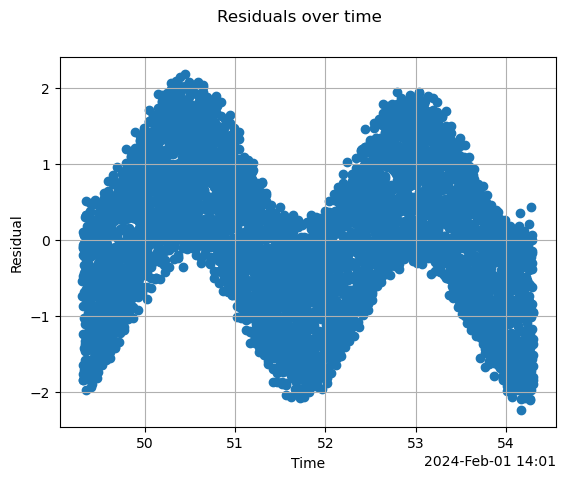

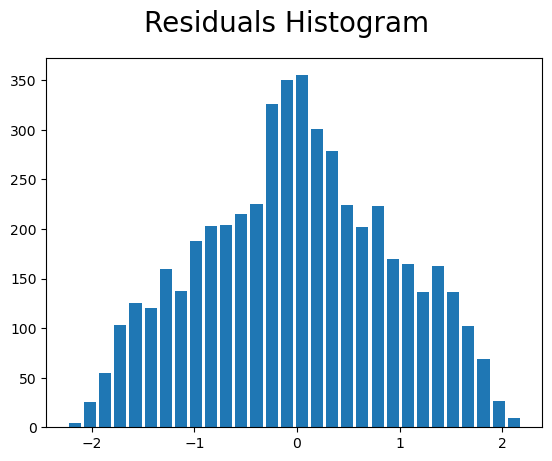


Validation plots:
------------------------------------------------------


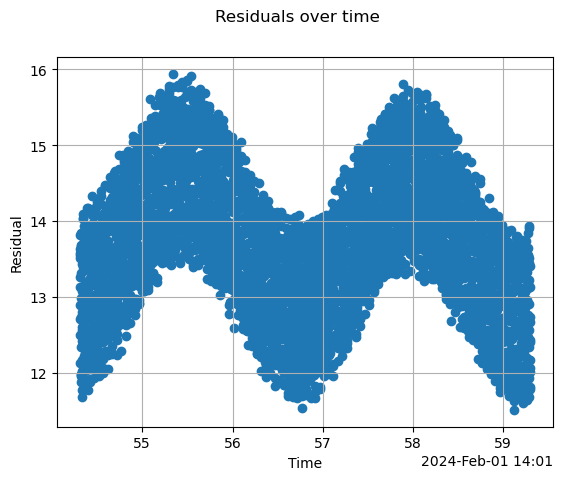

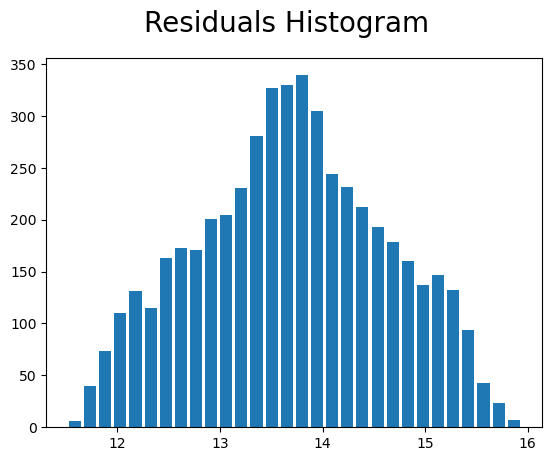

In [7]:
print("Fit with Char 2 dataset only")
result = solv.solve(char_set="char_2")
SSR = solv.validate()
solv.report(char_set="char_2", printout=True)